#### Team "We Like Wine"



1.Data cleaning and preprocessing

    a. Removing dups, imputing missing records, reducing data. 
    
2.Data grouping and preparing for Binary Classification Model

    a. Used NTLK ( preprocessed - tokenize - lemmatize )
    b. Used Labelencoder + HotEncoder to build numerical representations of words. 
    c. Train and Run classifier. 

In [103]:
# Creating a dataframe object
import pandas as pd
 

#wine_data= pd.read_csv(r'C:\Users\User\OneDrive\DataMining\winemag-data-130k-v2\winemag-data-130k-v2.csv', 
wine_data= pd.read_csv(r'C:\Users\User\OneDrive\DataMining\winemag-data-130k-v2_OpenRefine.csv', 
                        names=['country', 
                               'description', 
                               'designation', 
                               'points', 
                               'price', 
                               'province', 
                               'region_1', 
                               'region_2', 
                               'taster_name', 
                               'taster_twitter_handle', 
                               'title', 
                               'variety',
                               'winery'], skiprows=1#,low_memory=False
                        )

In [104]:
# Clean up 

#remove dups 
wine_data_nodups=wine_data.drop_duplicates()

#info
wine_data_nodups.info()

#remove nulls
nulls=wine_data_nodups.isnull().sum()
print("The number of nulls per feature is", '\n')
print(nulls)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
country                  119929 non-null object
description              119988 non-null object
designation              85443 non-null object
points                   119988 non-null int64
price                    111593 non-null float64
province                 119929 non-null object
region_1                 100428 non-null object
region_2                 46769 non-null object
taster_name              95071 non-null object
taster_twitter_handle    90542 non-null object
title                    119988 non-null object
variety                  119987 non-null object
winery                   119988 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB
The number of nulls per feature is 

country                     59
description                  0
designation              34545
points                       0
price                     8395
province     

In [105]:

#Drop values that are have few nulls
wine_data_nodups=wine_data_nodups.dropna(subset=['country','province','variety'])

#Drop counties with less than 100 reviews 
d=wine_data_nodups.groupby('country').count()
d = d.drop(d[(d['description']<100)].index,axis=0)
d.head()


,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
country,,,,,,,,,,,,
Argentina,3544,2693,3544,3501,3544,3495,0,3542,3542,3544,3544,3544
Australia,2197,1539,2197,2169,2197,2196,0,1910,1910,2197,2197,2197
Austria,3034,2582,3034,2536,3034,0,0,3026,3026,3034,3034,3034
Bulgaria,132,88,132,132,132,0,0,132,114,132,132,132
Canada,226,158,226,224,226,226,0,225,211,226,226,226


In [106]:

#remove egypt 
indexEgypt = wine_data_nodups[(wine_data_nodups['country']=='Egypt')].index
wine_data_nodups.drop(indexEgypt , inplace=True)
len(wine_data_nodups)

#impute the mean of the price to fill the nulls 
import numpy as np
wine_data_nodups['price_filled']=wine_data_nodups.groupby('country')['price'].transform(lambda grp: grp.fillna(np.mean(grp)))

print(nulls)

wine_data_nodups.nunique()

country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64


country                      42
description              119894
designation               37953
points                       21
price                       390
province                    424
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118779
variety                     575
winery                    16744
price_filled                411
dtype: int64

In [107]:
len(wine_data_nodups)

119927


### Visualization 


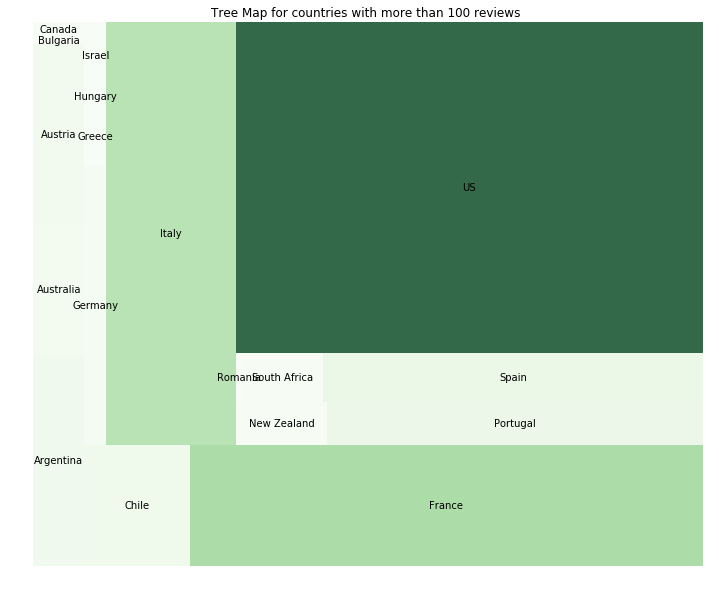

In [108]:
# tree MAP Tree Map example to visualize reviews by Country ?
import matplotlib.pyplot as plt
import matplotlib
import squarify  

d=wine_data_nodups.groupby('country').count()
d = d.drop(d[(d['description']<100)].index,axis=0)
 
norm = matplotlib.colors.Normalize(vmin=min(d['description']), vmax=max(d['description']))
colors = [matplotlib.cm.Greens(norm(value)) for value in d['description']] 

plt.figure(figsize=(12, 10))
squarify.plot(sizes=d['description'], label=d.index, alpha=.8 ,color = colors )
plt.axis('off')
plt.title("Tree Map for countries with more than 100 reviews ", fontsize=12)
plt.show()


Unique Scores are  {80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}


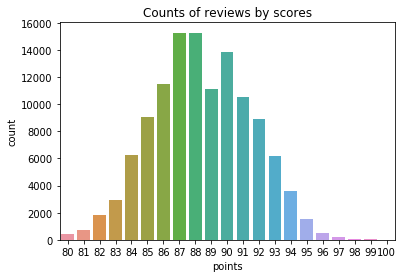

In [109]:
print("Unique Scores are ",set(wine_data_nodups['points']))

import seaborn as sns
sns.countplot(wine_data_nodups['points'])
plt.title('Counts of reviews by scores')
plt.show()

In [110]:
#Create buckets of points for easy classification Equal-width: equal bucket range ( as partition rule) 
import numpy as np
bins = np.array([80,90,100])
wine_data_nodups["bucket_points"] = pd.cut(wine_data_nodups['points'], bins, include_lowest=True)


In [111]:

bins = np.array([0,30,50,230])
wine_data_nodups["price_buckets"] = pd.cut(wine_data_nodups['price_filled'], bins, include_lowest=False)

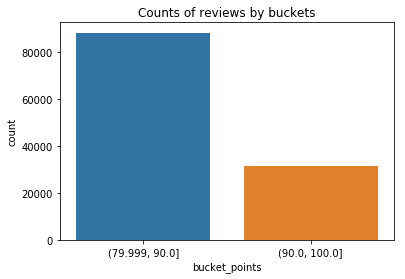

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(wine_data_nodups['bucket_points'])
plt.title('Counts of reviews by buckets')
plt.show()

### Outlier Analysis 

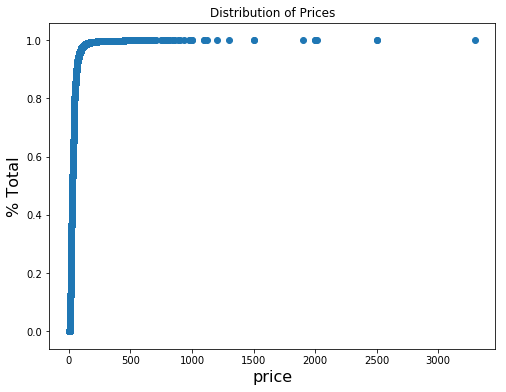

In [113]:
plt.figure(figsize=(8, 6))

import numpy as np
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

x,y=ecdf(wine_data_nodups['price_filled'])
plt.scatter(x=x, y=y)
plt.xlabel('price', fontsize=16)
plt.ylabel('% Total', fontsize=16)
plt.title('Distribution of Prices')
plt.show()

Q1 quantile of price :  18.0
Q2 quantile of price :  27.0
Q3 quantile of price :  41.99410536657252
0.995th quantile of arr :  225.0
IQR of price :  23.99410536657252
Outliers - Beyond 1.5xIQR :  35.99115804985878
wines of more than $230 =  558
total wines =  119927
total % of wines within $230  99.53471695281296


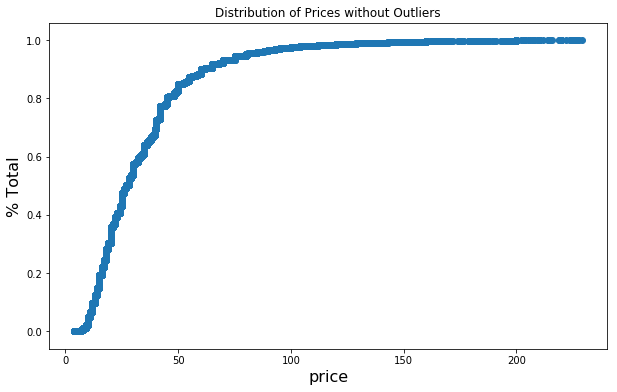

In [114]:
# numpy.quantile() method  
import numpy as np 

def IQR(dist):
    return np.quantile(dist, .75) - np.quantile(dist, .25)

 
print("Q1 quantile of price : ", np.quantile(wine_data_nodups['price_filled'], .25)) 
print("Q2 quantile of price : ", np.quantile(wine_data_nodups['price_filled'], .50))
print("Q3 quantile of price : ", np.quantile(wine_data_nodups['price_filled'], .75)) 
print("0.995th quantile of arr : ", np.quantile(wine_data_nodups['price_filled'], 0.995))  
print("IQR of price : ", IQR(wine_data_nodups['price_filled']))
print("Outliers - Beyond 1.5xIQR : ", 1.5*IQR(wine_data_nodups['price_filled']))


print('wines of more than $230 = ',len(wine_data_nodups[wine_data_nodups['price_filled']>=230]))
print('total wines = ',len(wine_data_nodups))
print('total % of wines within $230 ',
      (1-(len(wine_data_nodups[wine_data_nodups['price_filled']>=230])/len(wine_data_nodups)))*100)


d=wine_data_nodups
wine_data_nodups = d.drop(d[(d['price_filled']>=230)].index,axis=0)


plt.figure(figsize=(10, 6))
x,y=ecdf(wine_data_nodups['price_filled'])
plt.scatter(x=x, y=y)
plt.xlabel('price', fontsize=16)
plt.ylabel('% Total', fontsize=16)
plt.title('Distribution of Prices without Outliers')
plt.show()



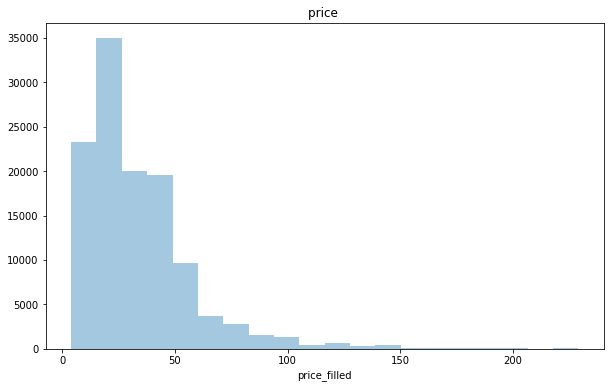

In [115]:
#look at distribution for price 
plt.figure(figsize=(10, 6))
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(wine_data_nodups['price_filled'], bins=20, kde=False, rug=False);
plt.title('price ')
plt.show()

Reviews for more frequent Varieties ( more than 100 reviews) : 113319


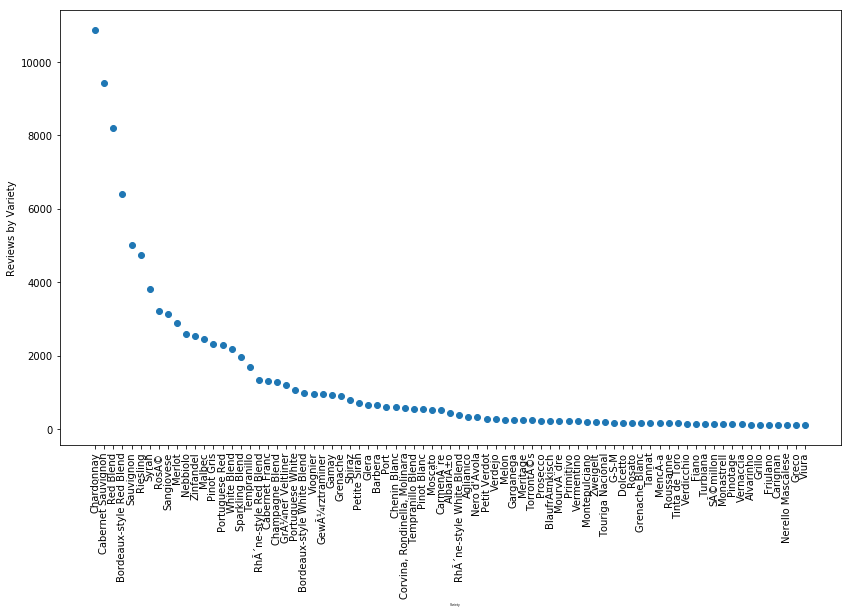

In [116]:


d=wine_data_nodups['variety'].value_counts()
d=d[d.values>100]
print("Reviews for more frequent Varieties ( more than 100 reviews) :",sum(d.values))
plt.figure(figsize=(14, 8))
plt.scatter(d.index[1:len(d)], d.values[1:len(d)])
plt.ylabel('Reviews by Variety')
plt.xlabel('Variety', fontsize=3,horizontalalignment='left')
plt.xticks(rotation=90)
plt.show()

In [117]:
d=wine_data_nodups['variety'].value_counts()
d=d[d.values>100]
print("Reviews for more frequent Varieties ( more than 100 reviews) :",sum(d.values))

Reviews for more frequent Varieties ( more than 100 reviews) : 113319


In [118]:
wine_data_final=wine_data_nodups.copy()
wine_data_final['variety_final'] = wine_data_final['variety']  
reds=[ "Red",
 "Pinot Noir",
 "Pinot",
 "cabernet",
 "bordeaux",
 "Shiraz",
 "Merlot",
 "Garnacha","Grenache",
 "Malbec",
 "Syrah",
 "Red Blend",
 "Zinfandel",
 "Sangiovese",
 "Nebbiolo",
 "Portuguese Red",
 "Tempranillo",
 "Gamay",
 "Petite Sirah",
 "Tempranillo Blend",
 "Barbera",
 "Sangiovese Grosso",
 "Port",
 "Corvina",
 "Garnacha",
 "Nero d'Avola",
 "Aglianico",
 "Petit Verdot",
 "Meritage",
 "MourvÃ¨dre",
 "Primitivo",
 "BlaufrÃ¤nkisch",
 "Montepulciano",
 "Monastrell",
 "Pinot Nero",
 "Tinta de Toro", "Bordeaux-style Red Blend",  "Corvina, Rondinella, Molinara",
 "Molinara", "Rhône-style Red Blend","RhÃ´ne-style Red Blend", "CarmenÃ¨re","Cabernet Franc", "Carmenère","Blaufränkisch","Mourvèdre","Zweigelt",
 "Touriga Nacional","Dolcetto"]
for i in reds:
    wine_data_final["variety_final"]=wine_data_final["variety_final"].replace(i,"R")
    
    
whites=["White",
 "Chardonnay",
 "Riesling",
 "Sauvignon",
 "Albarihno",
 "Verdejo",
 "Grenache Blanc",
 "Viura",
 "Macabeo",
 "Chardonnay-Pinot Blanc",
 "Pinot Blanc",
 "White Blend",
 "Pinot Gris",
 "Grüner Veltliner",
 "Viognier",
 "Portuguese White",
 "Bordeaux-style White Blend",
 "Gewürztraminer",
 "GewÃ¼rztraminer",
         "GrÃ¼ner Veltliner",
 "Glera",
 "Chenin Blanc",
 "AlbariÃ±o",
 "RhÃ´ne-style White Blend",
 "Pinot Blanc",
 "Moscato",
 "TorrontÃ©s",
 "Melon",
 "Garganega",
 "Verdelho",
 "Pinot Bianco", "Cabernet Sauvignon",
 "Sauvignon Blanc","Pinot Grigio", "Albariño","Rhône-style White Blend","Torrontés","Vermentino"]
for i in whites:
    wine_data_final["variety_final"]=wine_data_final["variety_final"].replace(i,"W")


rose=["Rose","Rosado","RosÃ©","Rosé"]
for i in rose:
    wine_data_final["variety_final"]=wine_data_final["variety_final"].replace(i,"Ro")  

    
sparkling=["Sparkling","Champagne","Lambrusco","Sparkling Blend","Champagne Blend","Prosecco"]
for i in sparkling:
    wine_data_final["variety_final"]=wine_data_final["variety_final"].replace(i,"Sp")  
    
    
wine_data_final["variety_final"].value_counts()




R                 60052
W                 44402
Sp                 3519
Ro                 3218
G-S-M               169
                  ...  
Other                 1
Biancolella           1
Merlot-Argaman        1
Pignolo               1
Pigato                1
Name: variety_final, Length: 508, dtype: int64

Varieties to Drop :  8178


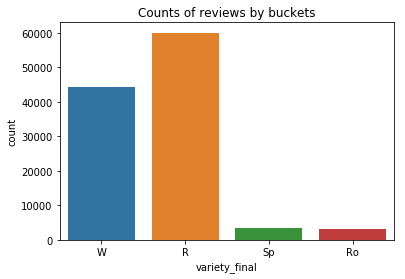

In [119]:
#iterate all varieties that we want to keep ( R, W,Ro,Sp) to create a list of varieties we want to drop to start our 
#binary classification 
varieties_todrop = wine_data_final.drop(wine_data_final[(wine_data_final['variety_final']=='R')].index,axis=0)
varieties_todrop = varieties_todrop.drop(wine_data_final[(wine_data_final['variety_final']=='W')].index,axis=0)
varieties_todrop = varieties_todrop.drop(wine_data_final[(wine_data_final['variety_final']=='Ro')].index,axis=0)
varieties_todrop = varieties_todrop.drop(wine_data_final[(wine_data_final['variety_final']=='Sp')].index,axis=0)

print("Varieties to Drop : ",len(varieties_todrop))
#now drop the data from the main dataframe
wine_data_final=wine_data_final.drop(varieties_todrop.index,axis=0)

wine_data_final["variety_final"].value_counts()


import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(wine_data_final['variety_final'])
plt.title('Counts of reviews by buckets')
plt.show()

In [120]:
#for Binary Classification - Drop Sp Ro

indexVariety = wine_data_final[(wine_data_final['variety_final']=='Sp')].index
wine_data_final.drop(indexVariety , inplace=True)

indexVariety = wine_data_final[(wine_data_final['variety_final']=='Ro')].index
wine_data_final.drop(indexVariety , inplace=True)

len(wine_data_final)

104454

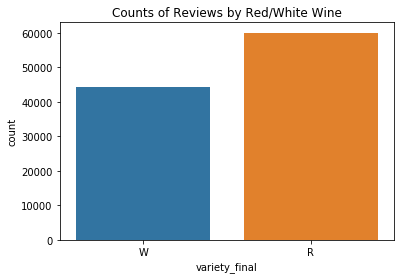

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(wine_data_final['variety_final'])
plt.title('Counts of Reviews by Red/White Wine')
plt.show()

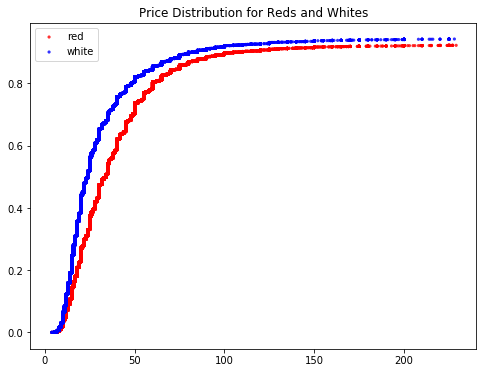

In [122]:
###Scatter map with 2 colors ( variety and price ) - using the function. 

import numpy as np
import matplotlib.pyplot as plt

# Create data
#pr=wine_data_final[(wine_data_final['variety_final']=='R')]['price']
#pw=wine_data_final[(wine_data_final['variety_final']=='W')]['price']

xr,yr=ecdf(wine_data_final[(wine_data_final['variety_final']=='R')]['price'])
xw,yw=ecdf(wine_data_final[(wine_data_final['variety_final']=='W')]['price'])

#g1 = (xr,yr)
#g2 = (xw,yw)


#data = (g1, g2)
#colors = ("red", "blue" )
#groups = ("red", "white")

# Create plot

fig = plt.figure(figsize=(8, 6))

#ax = fig.add_subplot(211)
plt.scatter(xr,yr, alpha=0.8, c="red", edgecolors='none', s=10, label="red")

#ax2 = fig.add_subplot(211)
plt.scatter(xw,yw, alpha=0.8, c="blue", edgecolors='none', s=10, label="white")

plt.title('Price Distribution for Reds and Whites')
plt.legend(loc=2)
plt.show()



In [123]:
wine_data_final = pd.get_dummies(wine_data_final, prefix_sep="_", 
                                   columns=['country'])
#wine_data_final = pd.get_dummies(wine_data_final, prefix_sep="_", 
 #                                  columns=['province'])


In [124]:
len(wine_data_final)

104454

In [125]:
#wine_data_final.head()
#wine_data_final.to_csv(r'C:\Users\User\OneDrive\DataMining\Exports\wine_data_final.csv')

### Text Mining 

we are also gonig to incorporate some text cleaning for the reviews 

preprocess, tokenize and stemm - 

In [126]:
text=wine_data_final['description']

In [127]:
import nltk
import os
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re  # Regular expressions

def preprocess(sentences):
    clean_data = []
    for sent in sentences: #this is Df_pd for Df_np (text[:])
        new_text = re.sub('<.*?>', '',sent)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case, .upper() for upper 
        if new_text != '':
            clean_data.append(new_text)
    return clean_data

def tokenization_s(sentences): # same can be achieved for words tokens
    s_new = []
    for sent in (sentences): #(sentences[:][0]) #For NumpY = sentences[:]
        s_token = word_tokenize(sent)
        if s_token != '':
            s_new.append(s_token)
    return s_new



In [128]:
preprocess=preprocess(text)
token=tokenization_s(preprocess)

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
clean_words=[]
for i in range(0,len(token)):
    words = [w for w in token[i] if not w in stop_words]
    clean_words.append(words)
    
    

In [129]:
print(len(preprocess))
print(len(token))


104454
104454


In [130]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()
lemma_words=[]
for i in range(0,len(clean_words)):
    lemma = [lemmatizer.lemmatize(word) for word in clean_words[i]]
    lemma_words.append(lemma)


In [131]:
#Build function to find frequent words 

def from_iterable_dup(iterables):
    bow_dup=[]
    for it in iterables:
        for element in it:
                bow_dup.append(element)
    return bow_dup

In [132]:
BoW_dup=from_iterable_dup(lemma_words)

from collections import Counter
a = dict(Counter(BoW_dup))
WordFreq=pd.DataFrame(list(a.items()), columns=['WordFreq', 'Count'])

In [28]:
#Visualization
#WordFreq.to_csv(r'C:\Users\User\OneDrive\DataMining\Exports\WordFreq.csv')

In [133]:
first100=WordFreq.sort_values(by=['Count'], ascending=False).head(106)
first100.drop(first100.index[:6], inplace=True)
print(first100.head())
len(first100)

    WordFreq  Count
27    tannin  28252
155   cherry  26892
19   acidity  26479
115    drink  24411
154    black  21893


100

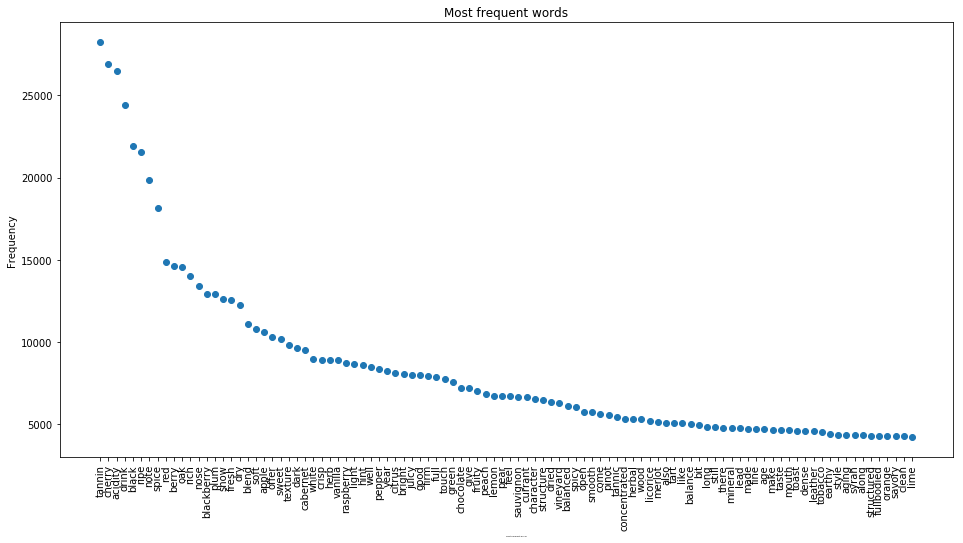

In [134]:
#d=wine_data_final['variety'].value_counts()
#d=d[d.values>100]
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.scatter(first100['WordFreq'], first100['Count'])
plt.ylabel('Frequency')
plt.xlabel('Most frequent words', fontsize=2,horizontalalignment='left')
plt.xticks(rotation=90)
plt.title("Most frequent words")
plt.show()

In [135]:
first100_l=first100['WordFreq'].to_list()

In [136]:

f_lemma_words=[]
for i in range(0,len(lemma_words)):
    words = [w for w in lemma_words[i] if w in first100_l]
    f_lemma_words.append(words)
    

In [137]:
len(f_lemma_words)

104454

In [138]:
f_lemma_df=pd.DataFrame(f_lemma_words,index=wine_data_final.index)
for i in range(0,25):
    f_lemma_df=f_lemma_df.rename(columns={i: "A"+str(i)})
f_lemma_df=f_lemma_df.rename(columns={25: "A25"})

In [139]:
#lcolumns=f_lemma_df.columns.to_list()
for i in f_lemma_df.columns.to_list():
    lcolumns.append(i)

In [140]:
for i in lcolumns:  
    f_lemma_df[i].fillna('CONSTANT', inplace=True)

In [141]:
f_lemma_df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25
0,dried,herb,apple,citrus,dried,acidity,CONSTANT,CONSTANT,CONSTANT,CONSTANT,...,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT
1,ripe,fruity,smooth,still,structured,firm,tannin,juicy,red,berry,...,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT
2,tart,lime,green,crisp,acidity,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,...,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT
3,lemon,orange,bit,note,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,...,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT
4,like,come,tannic,earthy,herbal,good,CONSTANT,CONSTANT,CONSTANT,CONSTANT,...,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT,CONSTANT


In [142]:
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
for i in lcolumns:  
    f_lemma_df[i]= le.fit_transform(f_lemma_df[i]) 

In [143]:
f_lemma_df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25
0,27,41,6,19,27,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72,35,76,80,82,33,87,44,70,9,...,0,0,0,0,0,0,0,0,0,0
2,88,51,40,23,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47,63,10,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,21,86,30,42,39,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
import warnings
warnings.filterwarnings("ignore")

# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 
onehotencoder = OneHotEncoder() 
  
data = onehotencoder.fit_transform(f_lemma_df).toarray()

In [145]:
data_df=pd.DataFrame(data,index=wine_data_final.index)

In [146]:
#wine_data_final=wine_data_final.drop(['description','designation','variety','title','winery','price','points','region_1', 'region_2', 'taster_name', 'taster_twitter_handle',],axis=1)
wine_data_final.columns

Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
       'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety',
       'winery', 'price_filled', 'bucket_points', 'price_buckets',
       'variety_final', 'country_Argentina', 'country_Australia',
       'country_Austria', 'country_Brazil', 'country_Bulgaria',
       'country_Canada', 'country_Chile', 'country_Croatia', 'country_Cyprus',
       'country_Czech Republic', 'country_England', 'country_France',
       'country_Georgia', 'country_Germany', 'country_Greece',
       'country_Hungary', 'country_India', 'country_Israel', 'country_Italy',
       'country_Lebanon', 'country_Luxembourg', 'country_Macedonia',
       'country_Mexico', 'country_Moldova', 'country_Morocco',
       'country_New Zealand', 'country_Peru', 'country_Portugal',
       'country_Romania', 'country_Serbia', 'country_Slovakia',
       'country_Slovenia', 'country_South Africa', 'country_Spain',
       'country_Switzerl

In [147]:
wine_data_final2=wine_data_final.drop(["winery",'province','description','designation','region_1', 'bucket_points', 'price_buckets', 'region_2', 'taster_name', 'taster_twitter_handle','title','variety','price'],axis=1)

In [148]:
wine_data_final2.columns

Index(['points', 'price_filled', 'variety_final', 'country_Argentina',
       'country_Australia', 'country_Austria', 'country_Brazil',
       'country_Bulgaria', 'country_Canada', 'country_Chile',
       'country_Croatia', 'country_Cyprus', 'country_Czech Republic',
       'country_England', 'country_France', 'country_Georgia',
       'country_Germany', 'country_Greece', 'country_Hungary', 'country_India',
       'country_Israel', 'country_Italy', 'country_Lebanon',
       'country_Luxembourg', 'country_Macedonia', 'country_Mexico',
       'country_Moldova', 'country_Morocco', 'country_New Zealand',
       'country_Peru', 'country_Portugal', 'country_Romania', 'country_Serbia',
       'country_Slovakia', 'country_Slovenia', 'country_South Africa',
       'country_Spain', 'country_Switzerland', 'country_Turkey', 'country_US',
       'country_Ukraine', 'country_Uruguay'],
      dtype='object')

In [149]:
d = pd.concat([wine_data_final2, data_df], axis=1, sort=False)

In [98]:
#import split the data 
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X=d.drop(['variety_final'],axis=1)
Y=d['variety_final']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 2) # 0.2 test_size means 20%
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Run Random Forest classifer  

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
accuracy_RFC = RFC.score(X_test, y_test)
print("Accuracy of our prediction without Province",accuracy_RFC)

(83563, 2008) (83563,)
(20891, 2008) (20891,)
Accuracy of our prediction 0.858312191852951


In [150]:
#import split the data 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X=d.drop(['variety_final'],axis=1)
Y=d['variety_final']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 2) # 0.2 test_size means 20%
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Run Random Forest classifer  

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
accuracy_RFC = RFC.score(X_test, y_test)
print("Accuracy of our prediction without Province",accuracy_RFC)

(83563, 2008) (83563,)
(20891, 2008) (20891,)
Accuracy of our prediction without Province 0.8582643243501986
